## Introduction
we will go through the training conv nets, ,preprocessing, data augmentation, model building etc.

In [35]:
import keras
from keras.layers import Input
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import load_img
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.models import Sequential
import cv2
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D,Dense
from pathlib import Path
from keras.preprocessing import image

In [36]:
import numpy as np
my_seed = 0
np.random.seed(my_seed)
import random 
random.seed(my_seed)
import tensorflow as tf
tf.random.set_seed(my_seed)

In [37]:
data_dir_train='../input/flowers-recognition/flowers/flowers'
Daisy_flower_dir = '../input/flowers-recognition/flowers/flowers/daisy/'
Sunflower_flower_dir = '../input/flowers-recognition/flowers/flowers/sunflower/'
Tulip_flower_dir = '../input/flowers-recognition/flowers/flowers/tulip/'
Dandelion_flower_dir = '../input/flowers-recognition/flowers/flowers/dandelion/'
Rose_flower_dir = '../input/flowers-recognition/flowers/flowers/rose/'

### Loading using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


In [41]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


### Visualize the data

tf.Tensor([1 0 1 0 0 4 4 1 1 4 1 1 2 2 3 1 1 1 4 4 2 1 4 2 1 1 2 4 1 2 0 2], shape=(32,), dtype=int32)
tf.Tensor([0 3 1 1 3 4 2 1 1 2 4 1 0 1 1 4 2 2 4 4 4 0 2 2 2 4 1 0 1 3 2 3], shape=(32,), dtype=int32)


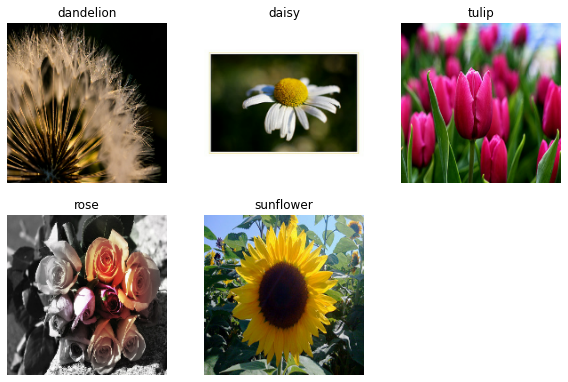

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
n=0
labels_taken=[]
for images, labels in train_ds.take(2):
  print(labels)
  for i in range(32):
    if (labels[i] not in labels_taken):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
      n+=1
      labels_taken.append(labels[i])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

### Model 1

In [44]:
num_classes = 5

model = Sequential()
model.add(Conv2D( filters=16, kernel_size=3, activation='relu',input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

### Compile the model

In [45]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.build((32,180,180,3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25600)            

### Train the model

In [47]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
109/109 [==============================] - 64s 514ms/step - loss: 62.0076 - accuracy: 0.2916 - val_loss: 1.6063 - val_accuracy: 0.3356
Epoch 2/20
109/109 [==============================] - 55s 506ms/step - loss: 1.3260 - accuracy: 0.4797 - val_loss: 1.6088 - val_accuracy: 0.3472
Epoch 3/20
109/109 [==============================] - 55s 504ms/step - loss: 1.0033 - accuracy: 0.6270 - val_loss: 1.4815 - val_accuracy: 0.4583
Epoch 4/20
109/109 [==============================] - 55s 501ms/step - loss: 0.7378 - accuracy: 0.7368 - val_loss: 1.6610 - val_accuracy: 0.4711
Epoch 5/20
109/109 [==============================] - 55s 504ms/step - loss: 0.5458 - accuracy: 0.8174 - val_loss: 1.9580 - val_accuracy: 0.4618
Epoch 6/20
109/109 [==============================] - 55s 502ms/step - loss: 0.3242 - accuracy: 0.8944 - val_loss: 2.6373 - val_accuracy: 0.4294
Epoch 7/20
109/109 [==============================] - 55s 501ms/step - loss: 0.2436 - accuracy: 0.9291 - val_loss: 2.6316 - val_a

### Visualizing training results

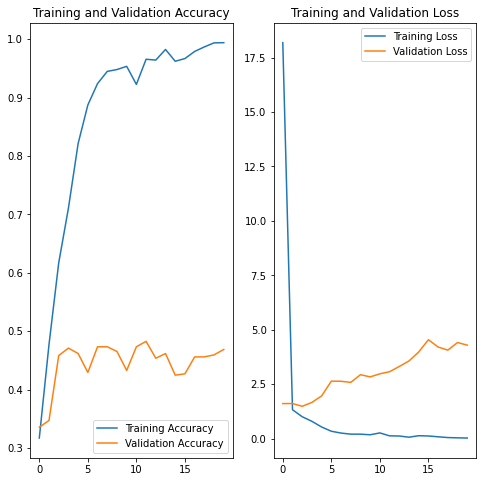

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Observations
- we can see that model is overfitting. 

## Using Image Data Generator to deal Overfitting

### Creating Model 2

In [49]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)


training_set = train_datagen.flow_from_directory(data_dir_train,
                                                 target_size = (img_height, img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',subset='training')

val_set = train_datagen.flow_from_directory(data_dir_train,
                                          target_size = (img_height, img_width),
                                          batch_size = batch_size,
                                          class_mode = 'categorical',subset='validation')

Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.


## Model 2

In [50]:
num_classes = 5

model = Sequential()
model.add(Conv2D( filters=16, kernel_size=3, activation='relu',input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.20))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

## Compile the Model

In [51]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 20, 20, 64)       

### Train the Model

In [53]:
epochs = 20
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.00003, patience=1, cooldown=2, verbose=1)]
history = model.fit(
  training_set,
  validation_data=val_set,
  epochs=epochs,callbacks=my_callbacks)

Epoch 1/20
109/109 [==============================] - 86s 784ms/step - loss: 1.5215 - accuracy: 0.2811 - val_loss: 1.2437 - val_accuracy: 0.4599
Epoch 2/20
109/109 [==============================] - 85s 778ms/step - loss: 1.1842 - accuracy: 0.5097 - val_loss: 1.1134 - val_accuracy: 0.5517
Epoch 3/20
109/109 [==============================] - 85s 776ms/step - loss: 1.0983 - accuracy: 0.5669 - val_loss: 0.9334 - val_accuracy: 0.6341
Epoch 4/20
109/109 [==============================] - 84s 773ms/step - loss: 0.9674 - accuracy: 0.6414 - val_loss: 0.8880 - val_accuracy: 0.6585
Epoch 5/20
109/109 [==============================] - 85s 776ms/step - loss: 0.9236 - accuracy: 0.6490 - val_loss: 0.9045 - val_accuracy: 0.6492

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/20
109/109 [==============================] - 84s 767ms/step - loss: 0.7858 - accuracy: 0.7004 - val_loss: 0.8190 - val_accuracy: 0.6945
Epoch 7/20
109/109 [============================

### Visualizing training results

Text(0.5, 1.0, 'Loss and Validation Loss')

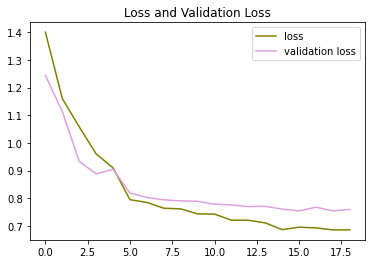

In [54]:
plt.figure()
plt.plot(history.history['loss'],color="olive", label='loss')
plt.plot(history.history['val_loss'], color="plum", label='validation loss')
plt.legend(loc='best')
plt.title(label="Loss and Validation Loss")

Text(0.5, 1.0, 'Accuracy and Validation Accuracy')

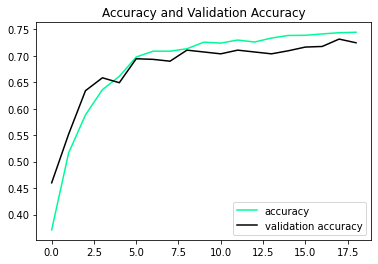

In [55]:
plt.figure()
plt.plot(history.history['accuracy'],color="mediumspringgreen", label='accuracy')
plt.plot(history.history['val_accuracy'], color="black", label='validation accuracy')
plt.legend(loc='best')
plt.title(label="Accuracy and Validation Accuracy")

## After Data Augmentation Model is not overfitting, Model gives train accuracy 74%, and val accuracy 70%